# Análisis de Redes Sociales: Festival de Eurovisión

**Integrantes:** Araceli Pérez Buendía. Sofía Maceín Sanz

Bibliografía básica: https://www.kaggle.com/code/jeleandro/network-analysis-applied-to-eurovision

## Índice

1. Introducción
2. Resumen y objetivos
3. Análisis exploratorio de los datos

### 1. Introducción

### 2. Resumen y objetivos

### 3. Análisis exploratorio de los datos

####  Paquetes y librerías

In [1]:
# Paquetes y librerias
import numpy as np 
import pandas as pd 
import pylab as plt
import seaborn as sns
from IPython.display import HTML

%matplotlib inline
sns.set_style('whitegrid')

#### 3.1. Carga de los datos y preliminares

In [2]:
# Dataset de eurovision 
df = pd.read_excel('eurovision_1975_2019.xlsx')
df.columns = ['year','final','edition','votetype','countryfrom','countryto','points','duplicate'];

# Visualizacion dataset
df.sample(5)

,year,final,edition,votetype,countryfrom,countryto,points,duplicate
27882,2011,sf1,2011sf1,J,Lithuania,Russia,5,NaN
2917,1983,f,1983f,J,Denmark,Cyprus,1,NaN
31440,2013,sf1,2013sf1,J,Cyprus,Austria,2,NaN
33784,2015,f,2015f,J,Czech Republic,Poland,0,NaN
10931,1999,f,1999f,J,Croatia,Turkey,0,NaN


Comenzamos con una exploración previa del dataset

In [3]:
# Dimension de los datos
print(df.shape)

# Tipo de variables
df.info()

(49832, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49832 entries, 0 to 49831
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         49832 non-null  int64 
 1   final        49832 non-null  object
 2   edition      49832 non-null  object
 3   votetype     49832 non-null  object
 4   countryfrom  49832 non-null  object
 5   countryto    49832 non-null  object
 6   points       49832 non-null  int64 
 7   duplicate    1528 non-null   object
dtypes: int64(2), object(6)
memory usage: 3.0+ MB


In [4]:
# Valores de las columnas
for col in df.columns:
    print(col, ': ', sorted(df[col].dropna().unique()), '\n')

year :  [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] 

final :  ['f', 'sf', 'sf1', 'sf2'] 

edition :  ['1975f', '1976f', '1977f', '1978f', '1979f', '1980f', '1981f', '1982f', '1983f', '1984f', '1985f', '1986f', '1987f', '1988f', '1989f', '1990f', '1991f', '1992f', '1993f', '1994f', '1995f', '1996f', '1997f', '1998f', '1999f', '2000f', '2001f', '2002f', '2003f', '2004f', '2004sf', '2005f', '2005sf', '2006f', '2006sf', '2007f', '2007sf', '2008f', '2008sf1', '2008sf2', '2009f', '2009sf1', '2009sf2', '2010f', '2010sf1', '2010sf2', '2011f', '2011sf1', '2011sf2', '2012f', '2012sf1', '2012sf2', '2013f', '2013sf1', '2013sf2', '2014f', '2014sf1', '2014sf2', '2015f', '2015sf1', '2015sf2', '2016f', '2016sf1', '2016sf2', '2017f', '2017sf1', '2017sf2', '2018f', '2018sf1', '20

En primer lugar,

* Eliminamos del dataset los países que no están conectados dado un año, es decir, aquellos con puntuación `points` $ = 0$.
* Eliminamos las entradas marcadas como duplicadas, `duplicates` = 'x', que corresponenden a la unión del país consigo mismo.
* Renombramos algunos países para mayor facilidad 
* Como para la construcción de la red final se tendrá en cuenta las ediciones a partir del año 2000, debido la incorporacion del televoto y la estabilidad política de los países, vamos a considerar los votos de Yugoslavia en sus correspondendientes estados actuales tras la disolución en 1992 (Bosnia y Herzegovina, Croacia, Eslovenia, Macedonia del Norte, Montenegro, Serbia, Kosovo).
* Eliminamos aquellos países con una baja participación, en particular, menor a 5 años o que no haya participado en los úlitmos 8 años.

Para todo esto, definimos una función `basicClean` en la que aplicamos los procedimientos explicados.

In [5]:
def basicClean(df, minYears = 5, last_participation = 8):
    
    # 1. ELiminamos puntuaciones de 0
    df2 = df.copy().query('points > 0')
    
    # 2. Eliminamos duplicados
    # Convertimos los valores 'x' a True y el resto a False
    df2['duplicate'] = df2['duplicate'].apply(lambda x: True if x == 'x' or x == True else False)
    # Nos quedamos con las filas en las que duplicate toma el valor False
    df2 = df2.query('duplicate == False').drop(columns=['duplicate'])

    
    # 3. Renombramos paises 
    def applyRename(x):
        # Creamos un diccionario con los paises a renombrar
        renamings = {
            'North Macedonia': 'Macedonia',
            'F.Y.R. Macedonia': 'Macedonia',
            'The Netherands': 'Netherlands', # debido a un error en los datos
            'The Netherlands': 'Netherlands',
            'Bosnia & Herzegovina': 'Bosnia'}
        # Si el pais esta entre los paises del diccionario, cambiamos el nombre; 
        # en caso contrario se devuelve el mismo nombre
        return renamings[x] if x in renamings else x

    # Aplicamos la funcion a las columnas con ls paises
    df2['countryfrom'] = df2['countryfrom'].apply(applyRename)
    df2['countryto']   = df2['countryto'].apply(applyRename)
    

    # 4. Division de Yugoslavia y Serbia & Montenegro a sus estados en la actualidad
    division = {
        'Yugoslavia': ['Macedonia', 'Serbia', 'Montenegro', 'Slovenia', 'Bosnia','Croatia'],
        'Serbia & Montenegro': ['Serbia', 'Montenegro']}
    
    df2['countryfrom'] = df2['countryfrom'].apply(lambda x:division[x] if x in division else x)
    df2['countryto']   = df2['countryto'].apply(lambda x:division[x] if x in division else x)
    
    df2 = df2.explode('countryfrom').explode('countryto')
    # Cada cambio que involucre a varios paises se desglosa entre los
    # pares de paises correspondientess
    
        
    # 5. Eliminamos aquellos paises que hayan participado menos 5 veces
    # y que no han estado activos en los ultimos 5 años
    
    # Calculamos numero de años participados y cuantos años han pasado desde 
    # utlima participacion
    toKeep = df2.groupby('countryfrom').apply(lambda x:pd.Series(
        {'years': x['year'].nunique(),
        'last_participation': df2['year'].max() - x['year'].max()
    })).query(f'years >= {minYears} and last_participation <= {last_participation}').reset_index()['countryfrom']
    # Asi obtenemos la lista de paises que cumplen los requisitos
    
    # Mostramos los paises que no cumplen los requisitos
    display(HTML("<p>ignored countries: %s</p>" %', '.join(df2[df2['countryfrom'].isin(toKeep)==False]['countryfrom'].unique())))

    df2 = df2[df2['countryfrom'].isin(toKeep)]
    df2 = df2[df2['countryto'].isin(toKeep)]
    
    

    # 6. Tomamos los puntos unicamente de la final
    df2['finalcode'] = df2.final.map({'f':1, 'sf':2,'sf1':2,'sf2':2})
    temp1 = df2.groupby(['countryto','year']).agg({'finalcode':'min'});
    df2 = pd.merge(df2,temp1, on=['countryto','year','finalcode'], how='inner')
    
    assert len(df2.groupby(['countryfrom','countryto','year']).agg({'final':'nunique'}).query('final >1')) == 0
    
    df2.drop(columns=['finalcode','edition'], inplace=True)
    
    return df2.reindex()

In [6]:
# Aplicamos la funcion al dataset original
df2 = basicClean(df)

# Dimnesion del nuevo dataset
print('Dimension del nuevo dataset: ', df2.shape, '\n')

# Visualizacion del dataset
df2.sample(5)

Dimension del nuevo dataset:  (17199, 6) 



,year,final,votetype,countryfrom,countryto,points
313,1976,f,J,Finland,Switzerland,7
920,1980,f,J,Austria,Italy,2
7855,2005,f,J,Sweden,Denmark,10
5858,1999,f,J,Poland,Denmark,1
198,1975,f,J,Germany,Belgium,7


#### 3.2. Análisis exploratorio de los datos

El objetivo de esta sección es estudiar la posible distribución subyecente de los datos, así como posibles outliers o valores atípicos. Con ello, pretendemos crear una red que recoja la información básica del concurso a lo largo de los años para dar respuesta a las preguntas planteadas.

In [7]:
# Dataset
df2.sample(5)

,year,final,votetype,countryfrom,countryto,points
508,1977,f,J,Germany,Spain,7
2322,1986,f,J,Bosnia,Spain,4
12008,2013,f,J,Estonia,Iceland,6
4470,1993,f,J,Iceland,Sweden,7
2378,1986,f,J,Denmark,United Kingdom,8


**1) Participación a lo largo de los años:** Gráfico del número de puntos totales que se han dado a lo largo de los años en la categoría de final. Tratamos de comprender el crecimiento de Eurovisión y el interés de los países a lo largo del tiempo.

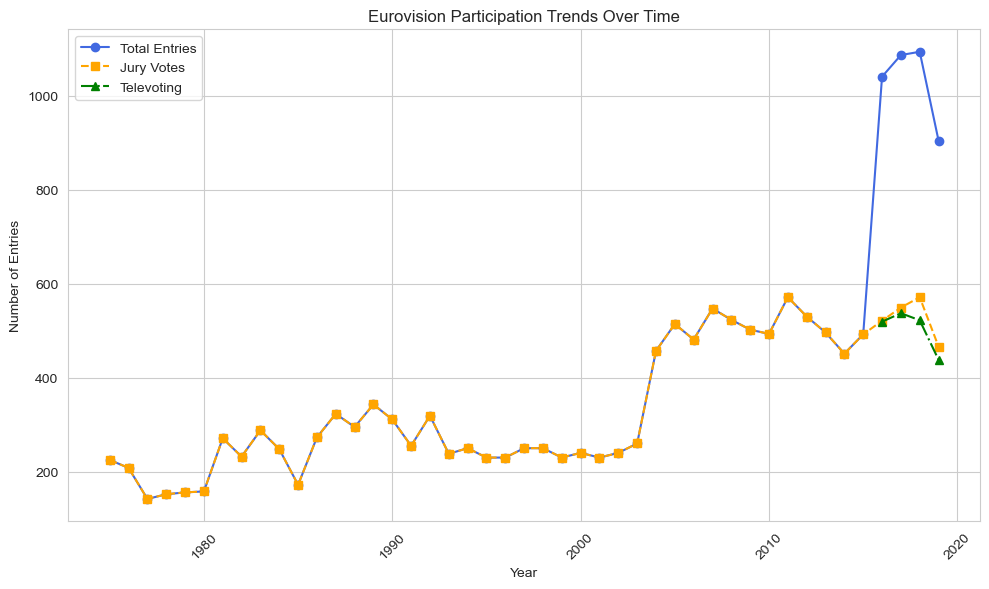

In [8]:
# Convertimos la columna 'year' a formato datetime
df2['year'] = pd.to_datetime(df2['year'], format='%Y')

# Agrupamos por año y contamos el número de entradas 
participation_counts_total = df2.groupby(df2['year'].dt.year).size() # totales
participation_counts_J = df2[df2['votetype'] == 'J'].groupby(df2['year'].dt.year).size() # jurado
participation_counts_T = df2[df2['votetype'] == 'T'].groupby(df2['year'].dt.year).size() # televoto

# Grafico de las tendencias de participación
plt.figure(figsize=(10, 6))

participation_counts_total.plot(marker='o', color='royalblue', linestyle='-', label='Total Entries')
participation_counts_J.plot(marker='s', color='orange', linestyle='--', label='Jury Votes')
participation_counts_T.plot(marker='^', color='green', linestyle='-.', label='Televoting')

plt.title('Eurovision Participation Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Breve explicación del aumento de votos:

* 1997-2008: Televoto
* 2009-2015: Sistema Mixto
* 2016 - Televoto(app)

**2) Distribución de puntos por país:** Create a histogram or a box plot to visualize the distribution of points received by each country. This can provide insights into the fairness and consistency of the voting process.

<Figure size 1200x800 with 0 Axes>

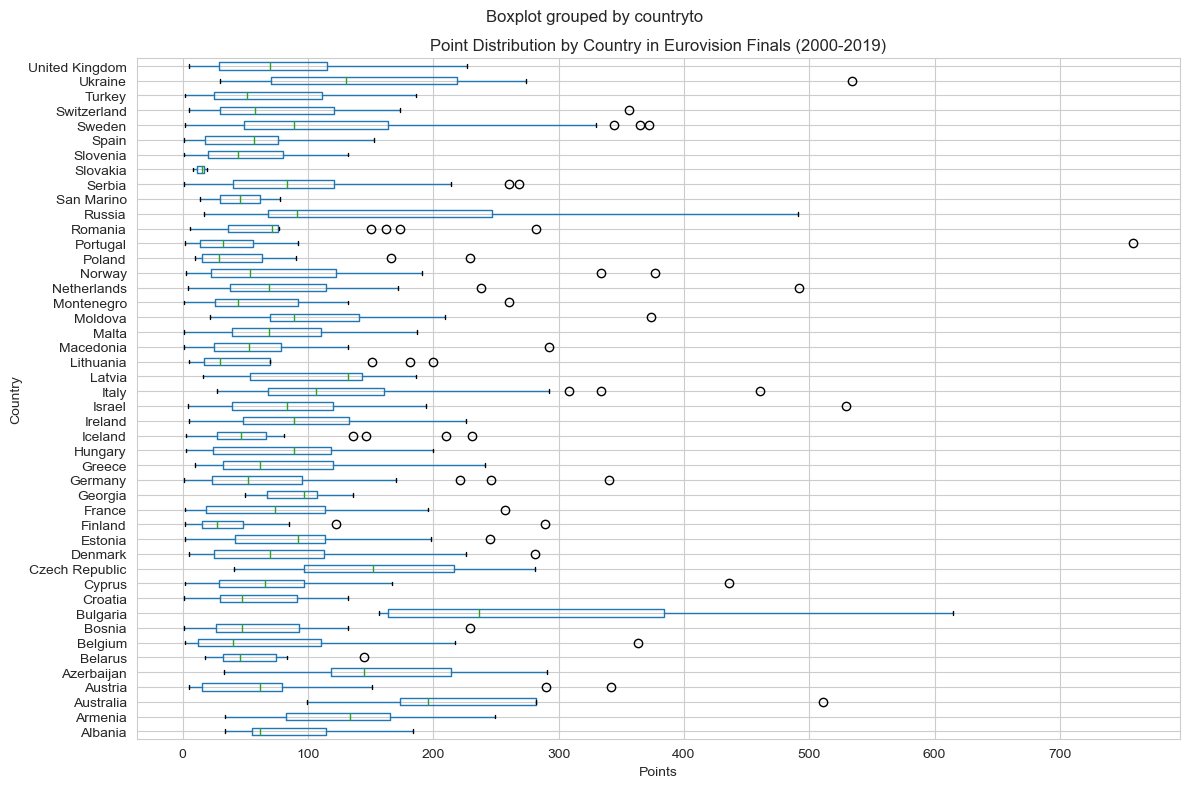

In [9]:
# Categoria de final (f)
df_final = df2[df2['final'] == 'f']
points_by_country_year = df_final.groupby(['countryto', df_final['year'].dt.year])['points'].sum().reset_index()

# Grafico boxplot
plt.figure(figsize=(12, 8))
boxplot = points_by_country_year.boxplot(column='points', by='countryto', vert=False, figsize=(12,8))

plt.title('Point Distribution by Country in Eurovision Finals (2000-2019)')
plt.xlabel('Points')
plt.ylabel('Country')
plt.grid(True)
plt.tight_layout()
plt.show()

**3) Mapa de calor del intercambio de puntos:** Tratamos de ver patrones de alianzas/amistades entre países e identificar grupos de países que a menudo se votan entre sí.

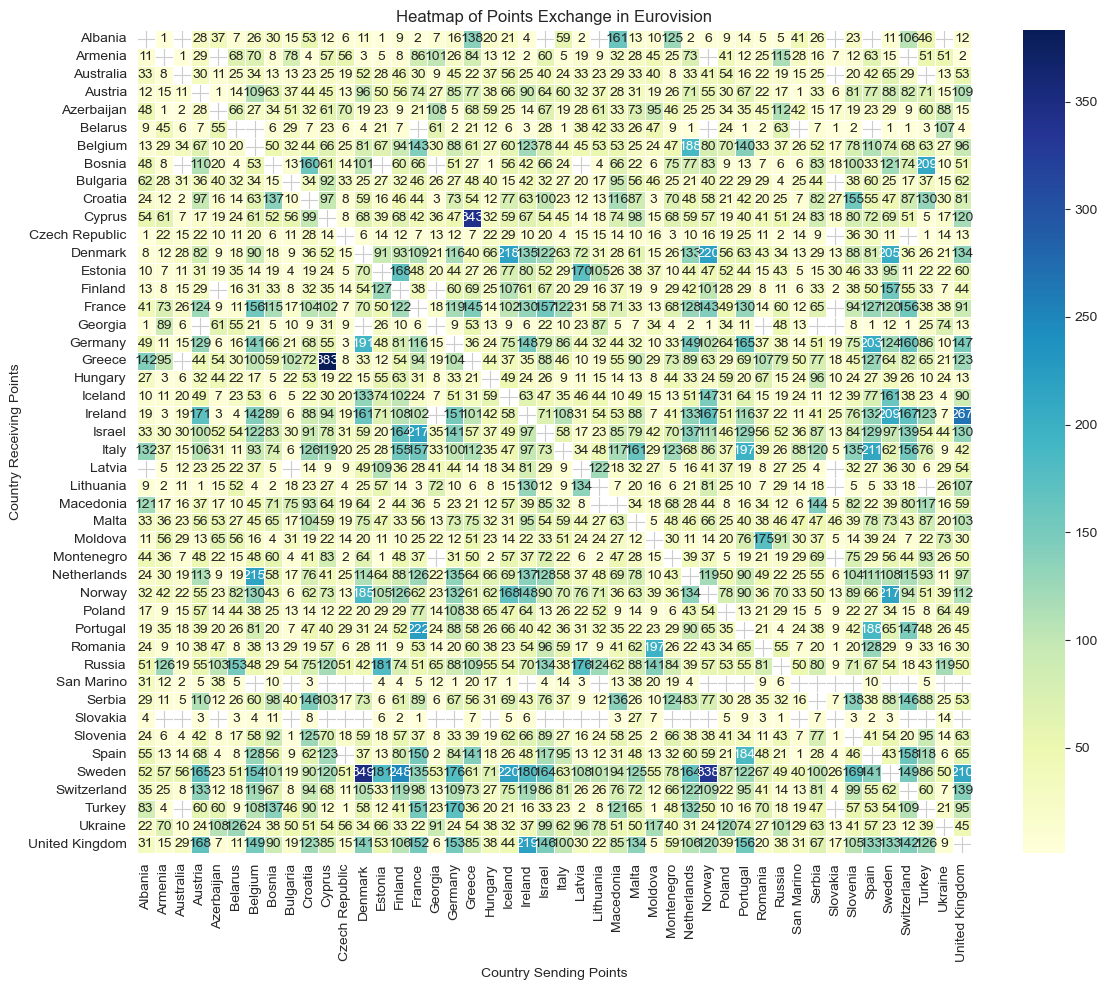

In [10]:
# Intercambio de puntos
points_matrix = df2.pivot_table(index='countryto', columns='countryfrom', values='points', aggfunc='sum')

# Grafico
plt.figure(figsize=(12, 10))
sns.heatmap(points_matrix, cmap='YlGnBu', annot=True, fmt='g', linewidths=.5)
plt.title('Heatmap of Points Exchange in Eurovision')
plt.xlabel('Country Sending Points')
plt.ylabel('Country Receiving Points')
plt.tight_layout()
plt.show()

**4) Summary of participation by country in the Eurovision contest:** including the number of unique years a country participated, the earliest year of participation, the latest year of participation, and the presence percentage, which represents the proportion of years the country participated relative to the total number of years available.

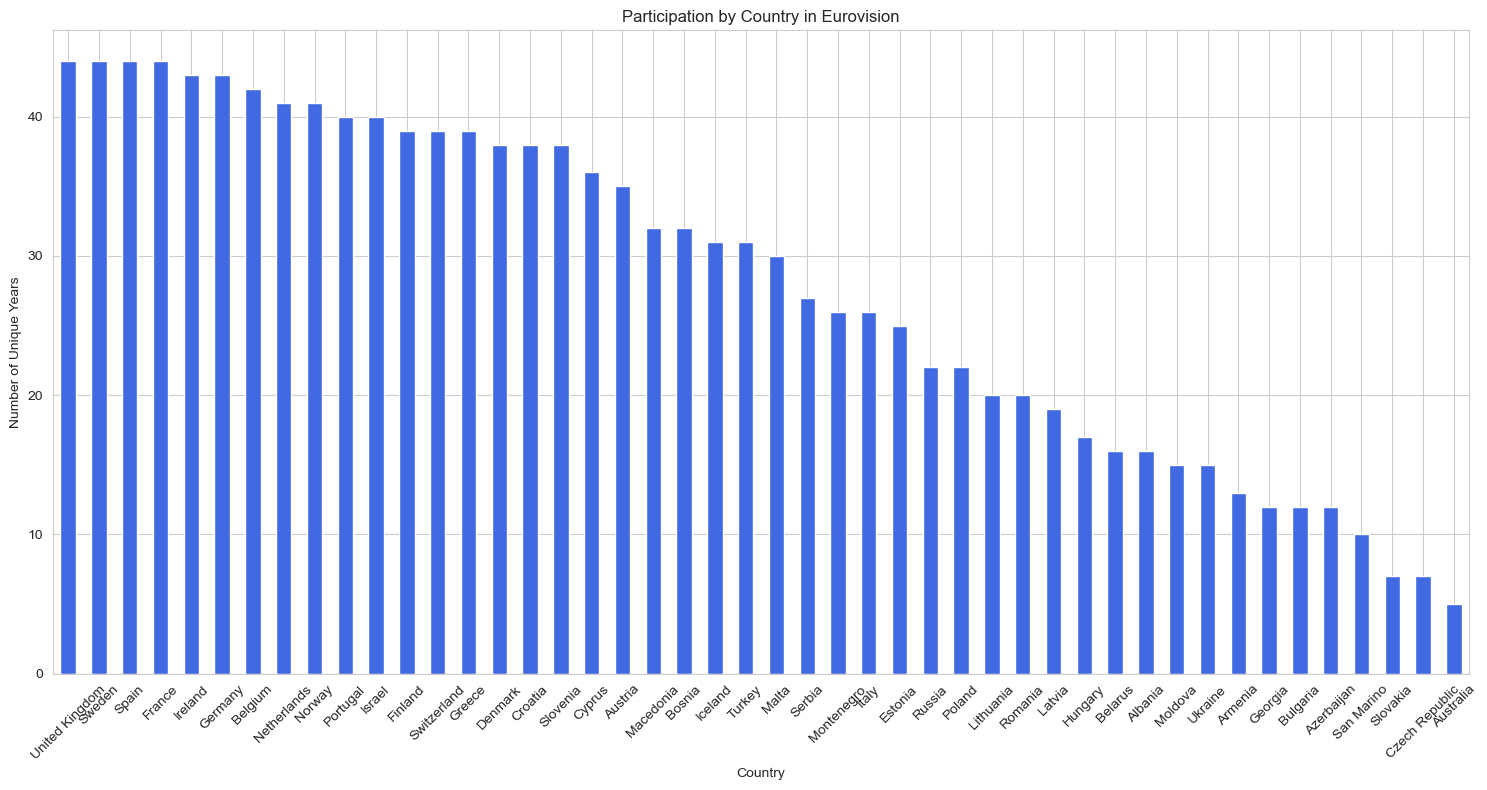

In [11]:
# Generate the summary of participation by country
participation_summary = df2.groupby(['countryto']).apply(lambda x: pd.Series({
    'nyear': x['year'].nunique(),
    'min_year': x['year'].min().year,
    'max_year': x['year'].max().year,
    'presence': int(100 * x['year'].nunique() / (x['year'].max().year - x['year'].min().year + 1))
}))

# Sort the summary by the number of unique years in descending order
participation_summary_sorted = participation_summary.sort_values('nyear', ascending=False)# Plot the participation by country as a bar chart
plt.figure(figsize=(15, 8))
participation_summary_sorted['nyear'].plot(kind='bar', color='royalblue')
plt.title('Participation by Country in Eurovision')
plt.xlabel('Country')
plt.ylabel('Number of Unique Years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Winners**

In [12]:
#The Winner
df2.query('final =="f"')\
    .groupby(['countryto','year']).agg({'points':'sum'}).reset_index()\
    .groupby('year').apply(lambda x:x.sort_values('points').tail(1)).reset_index(drop=True)\
    .sort_values('year',ascending=False)\
    .head(12).T.style.set_caption("The Winners").hide_index()\
    #.bar(subset=['points'], color='#d65f5f')

C:\Users\sofia\AppData\Local\Temp\ipykernel_4996\2000270484.py:6: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  .head(12).T.style.set_caption("The Winners").hide_index()\


44,43,42,41,40,39,38,37,36,35,34,33
Netherlands,Israel,Portugal,Ukraine,Sweden,Austria,Denmark,Sweden,Azerbaijan,Germany,Norway,Russia
2019-01-01 00:00:00,2018-01-01 00:00:00,2017-01-01 00:00:00,2016-01-01 00:00:00,2015-01-01 00:00:00,2014-01-01 00:00:00,2013-01-01 00:00:00,2012-01-01 00:00:00,2011-01-01 00:00:00,2010-01-01 00:00:00,2009-01-01 00:00:00,2008-01-01 00:00:00
492,529,758,534,365,290,281,372,221,246,377,267


### 4. Visualización del grafo

In [13]:
# Paquetes y Librerias
import networkx as nx

In [14]:
# Funciones de selecciones de porcentaje
def selectTopN(x, column, top=3):
    x = x.sort_values(column, ascending=False).head(top)
    return x

def selectTopPercent(x, column, percent=0.2, retrieve_first=True):
    x = x.sort_values(column, ascending=False)
    cut = x[column].cumsum() / x[column].sum()
    cut = cut <= percent
    
    # Return at least the first and avoid warnings
    if retrieve_first and cut.sum() == 0:
        return x.iloc[0]
    
    return x[cut]

Visualizamos, por año en la fase final el grafo resultante de la agregacion de votos y televotos.

In [52]:
def plot_eurovision_graph(df, year, percent=0.3):
    # Agregar el televoto y el voto del jurado
    temp = df2.groupby(['year', 'final', 'countryfrom', 'countryto']).agg({'points':'sum'})\
    .reset_index().rename(columns={'points':'weight'})
    
    # Seleccion de fase final de un año 
    df_year = temp[(temp['year'].dt.year == year) & (temp['final'] == 'f')]
    
    # Crear el grafo original con todas las conexiones
    G = nx.from_pandas_edgelist(df_year, 'countryfrom', 'countryto', ['weight'], create_using=nx.DiGraph)
    pos1 = nx.circular_layout(G) #layout del primer grafo
    
    # Crear el segundo grafo con el porcentaje de los pesos mas altos
    selected_edges = selectTopPercent(df_year, 'weight', percent=percent)
    G2 = nx.from_pandas_edgelist(selected_edges, 'countryfrom', 'countryto', ['weight'], create_using=nx.DiGraph)
    pos2 = nx.kamada_kawai_layout(G2, weight='weight') # layout del segundo grafo    
    
    # Graficos
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Grafo original
    nx.draw(G, pos1, ax=axs[0], with_labels=True, node_color=list(nx.pagerank(G).values()),
            cmap=plt.cm.viridis_r, edge_color='#cccccc', font_color='#000', font_size=10, font_weight='bold', arrows=True)
    axs[0].set_title(f'Directed Graph of Points Exchange in Eurovision {year} (Original)')
    axs[0].axis('off')
    
    # Grafo con el porcentaje seleccionado
    nx.draw(G2, pos2, ax=axs[1], with_labels=True, node_color=list(nx.pagerank(G2).values()),
            cmap=plt.cm.viridis_r, edge_color='#cccccc', font_color='#000', font_size=10, font_weight='bold', arrows=True)
    axs[1].set_title(f'Directed Graph of Points Exchange in Eurovision {year} (30% of Edge Weight)')
    axs[1].axis('off')
    

    plt.tight_layout()
    plt.show()

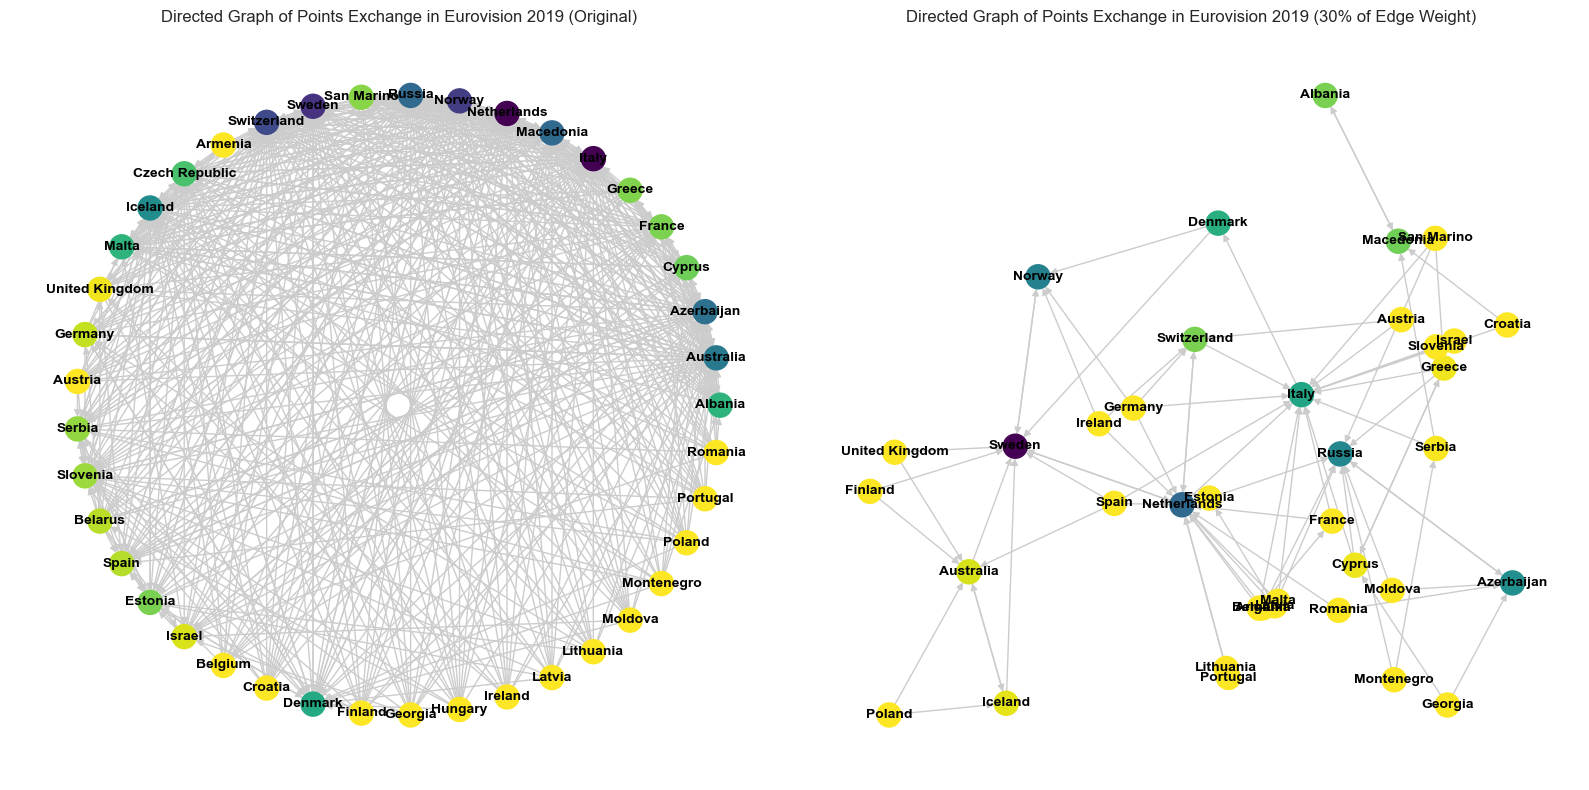

In [54]:
# Final 2019
plot_eurovision_graph(df2, 2019, percent=0.3)

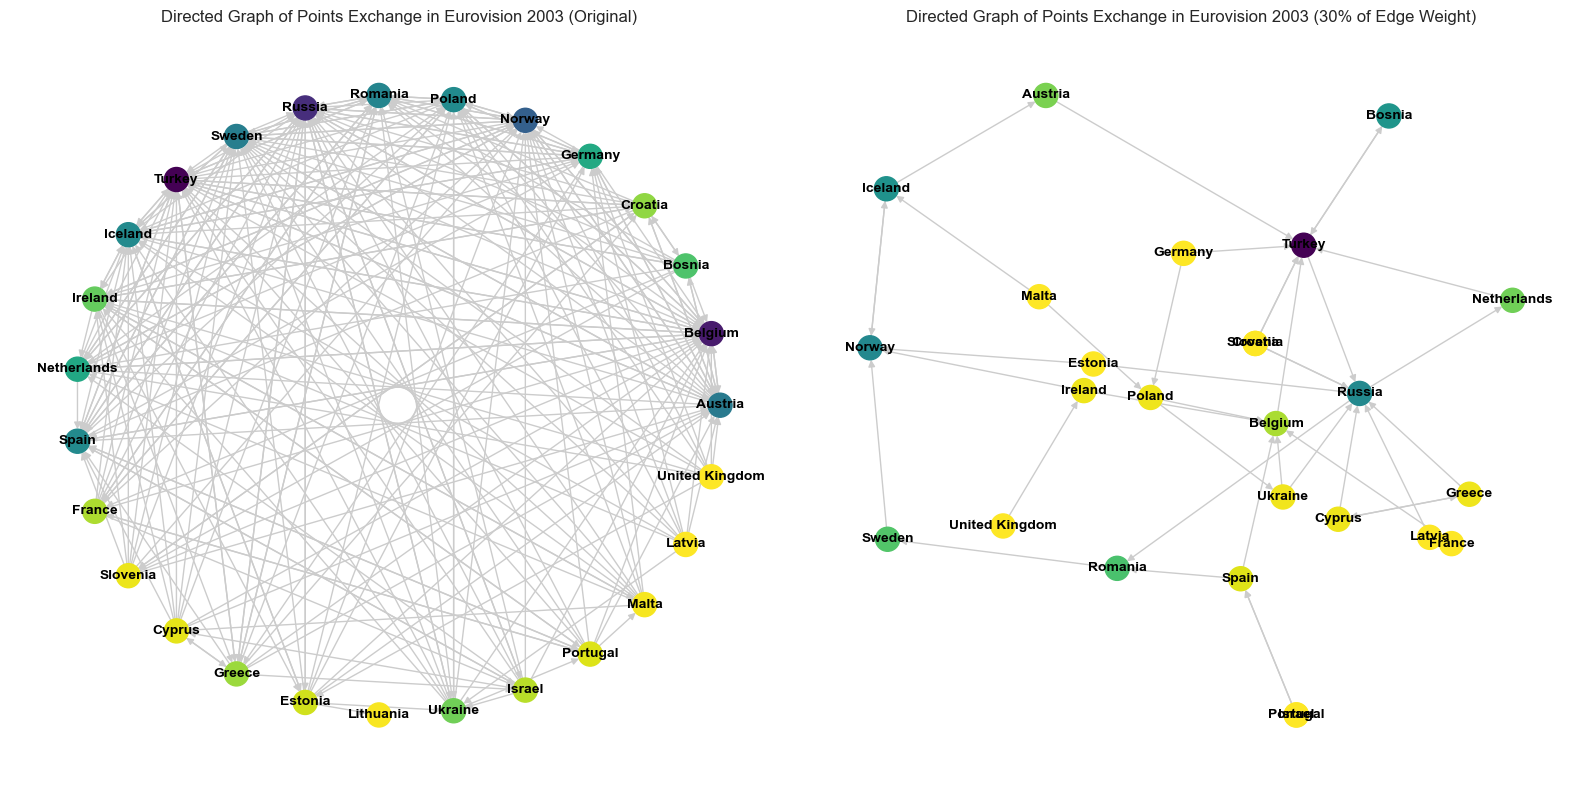

In [55]:
# Final 2003
plot_eurovision_graph(df2, 2003, percent=0.3)

### 5. Explorción de estructuras subyacentes del grafo

**Triadas**